<a href="https://colab.research.google.com/github/Sitta250/pytorch/blob/main/04_pytorch_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cpu'

In [8]:
# get data from Food101 dataset
# 1000img: 750 training and 250 testing
import requests
import zipfile
from pathlib import Path

# setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steack_sushi"

# if img folder doesn't exist, already existed
if image_path.is_dir():
  print(f"{image_path} dir already existed. skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# download
with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
  requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(requests.content)

# unzip data
with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping pizza, steak, sushi data")
  zip_ref.extractall(image_path)

data/pizza_steack_sushi dir already existed. skipping download
unzipping pizza, steak, sushi data


In [9]:
# data prepping
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filename in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filename)} images in '{dir_path}")


In [10]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steack_sushi
There are 3 directories and 0 images in 'data/pizza_steack_sushi
There are 0 directories and 31 images in 'data/pizza_steack_sushi
There are 0 directories and 25 images in 'data/pizza_steack_sushi
There are 0 directories and 19 images in 'data/pizza_steack_sushi
There are 3 directories and 0 images in 'data/pizza_steack_sushi
There are 0 directories and 72 images in 'data/pizza_steack_sushi
There are 0 directories and 78 images in 'data/pizza_steack_sushi
There are 0 directories and 75 images in 'data/pizza_steack_sushi


In [11]:
# setup train and testing path
train_dir = image_path/ "train"
test_dir = image_path/ "test"

train_dir, test_dir

(PosixPath('data/pizza_steack_sushi/train'),
 PosixPath('data/pizza_steack_sushi/test'))

random img path: data/pizza_steack_sushi/test/pizza/1503858.jpg
image class: pizza
image height: 384
image width: 512


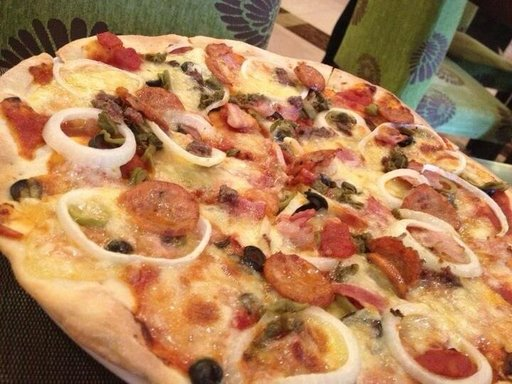

In [26]:
# visualizing
import random
from PIL import Image


# get img path path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# pick a random path
random_image_path = random.choice(image_path_list)

# extract img class = name of directory
image_class = random_image_path.parent.stem

# open img
img = Image.open(random_image_path)

# print metadata
print(f"random img path: {random_image_path}")
print(f"image class: {image_class}")
print(f"image height: {img.height}")
print(f"image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

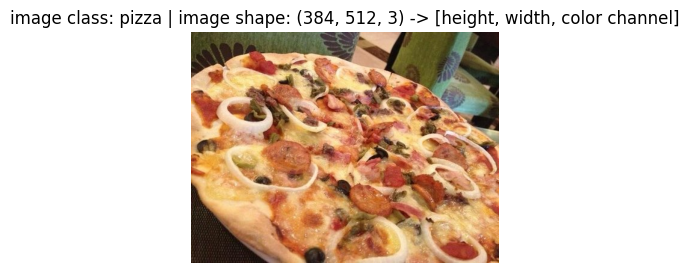

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# turn img to array
img_as_array = np.asarray(img)

# plot img with plt
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.title(f"image class: {image_class} | image shape: {img_as_array.shape} -> [height, width, color channel]")
plt.axis(False)

array([[[ 63,  59,  30],
        [ 53,  49,  20],
        [ 58,  53,  23],
        ...,
        [ 39,  18,  17],
        [ 39,  15,  13],
        [ 40,  16,  14]],

       [[ 82,  78,  49],
        [ 63,  60,  29],
        [ 59,  54,  24],
        ...,
        [ 36,  15,  14],
        [ 37,  13,  11],
        [ 37,  13,  11]],

       [[ 86,  83,  52],
        [ 64,  61,  30],
        [ 56,  53,  22],
        ...,
        [ 37,  16,  15],
        [ 38,  14,  12],
        [ 39,  15,  13]],

       ...,

       [[ 44,  27,  17],
        [ 63,  46,  36],
        [ 76,  59,  49],
        ...,
        [148,  87,  33],
        [132,  73,  17],
        [122,  63,   5]],

       [[ 35,  18,   8],
        [ 53,  36,  26],
        [ 61,  44,  34],
        ...,
        [189, 128,  71],
        [167, 108,  48],
        [151,  93,  30]],

       [[ 40,  23,  13],
        [ 53,  36,  26],
        [ 55,  38,  28],
        ...,
        [217, 157,  97],
        [199, 139,  77],
        [181, 123,  59]]], dtype=uint8)
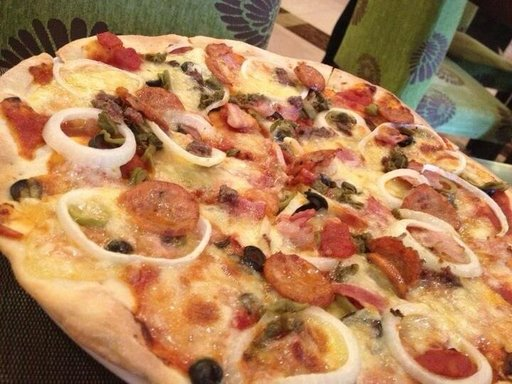

In [28]:
img_as_array

In [31]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [35]:
# write a transform for img
data_transform = transforms.Compose([
    # resize img to 64x64
    transforms.Resize(size=(64, 64)),
    # flip img randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # turn img to tensor
    transforms.ToTensor(),
])

In [42]:
data_transform(img).dtype

torch.float32

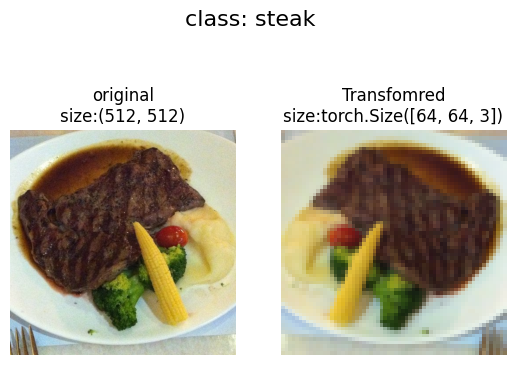

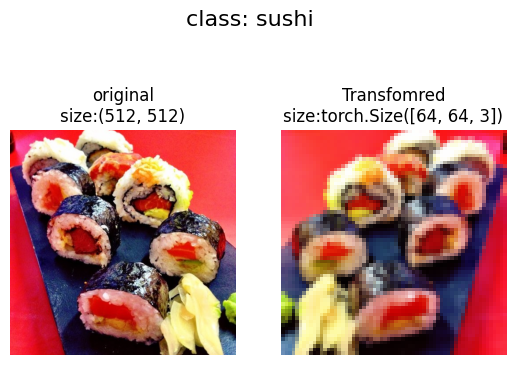

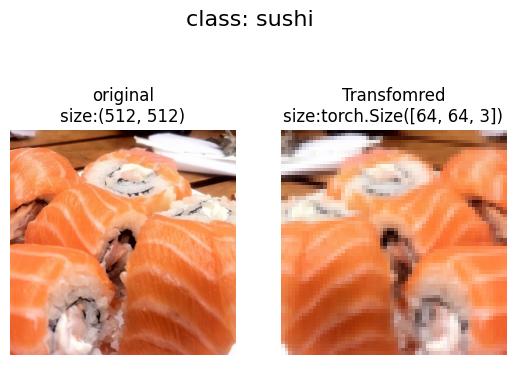

In [45]:
def plot_transformed_img(image_paths, transform, n=3, seed=None):
  """
  select random img from path of img and load/transform then plot original vs transformed
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols= 2)
      ax[0].imshow(f)
      ax[0].set_title(f"original\nsize:{f.size}")
      ax[0].axis(False)

      # transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # keep in mind that this will return color first but plt wants color at last position so we need to use .permute()
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transfomred\nsize:{transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)

plot_transformed_img(image_paths=image_path_list,
                     transform=data_transform,
                     n=3,
                     seed=42)

In [48]:
# option1: loading using ImageFolder
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steack_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steack_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [49]:
# get class name as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [50]:
# get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [51]:
len(train_data), len(test_data)

(225, 75)

In [54]:
train_data.samples[0]

('data/pizza_steack_sushi/train/pizza/1008844.jpg', 0)

In [60]:
# index on train_data dataset to get single img and label
img, label = train_data[0][0], train_data[0][1]
print(f"image tensor:\n {img}")
print(f"image shape: {img.shape}")
print(f"image datatype: {img.dtype}")
print(f"image label: {label}")
print(f"data datatype: {type(label)}")

image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
img permute: torch.Size([64, 64, 3]) -> [height, width, color]


Text(0.5, 1.0, 'pizza')

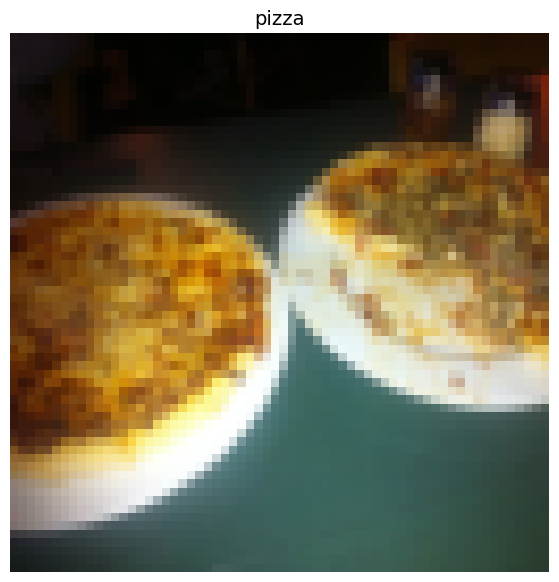

In [62]:
img_permute = img.permute(1,2,0)

# print out shape
print(f"original shape: {img.shape} -> [color_channels, height, width]")
print(f"img permute: {img_permute.shape} -> [height, width, color]")

# plotting
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [59]:
class_names[label]

'pizza'

In [63]:
import os
os.cpu_count()

2

In [71]:
# turn train and test dataset ino DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c658a3e3dd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c6579a796d0>)

In [72]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [73]:
len(train_data), len(test_data)

(225, 75)

In [75]:
img, label = next(iter(train_dataloader))

print(f"img shape: {img.shape}-> [batch_size, color, height, width]")
print(f"label shape: {label.shape}")

img shape: torch.Size([1, 3, 64, 64])-> [batch_size, color, height, width]
label shape: torch.Size([1])


In [76]:
# option2: loading data with Custom Dataset

# pro: can create Dataset out of anything, not limited to prebuilt 'Dataset' function

# cons: doesn't guarantee that Dataset will always work, prone to errors or performance issues


import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [77]:
# instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [79]:
# create helper func to get class names
# get class name using os.scandir() and raise error if class name aren't found


# setup path for target directory
target_directory = train_dir

#get class name
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [80]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [83]:
def find_classes(directory: str)->Tuple[List[str], Dict[str,int]]:
  # get class name
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"couldn't find any classes in {directory}... please check file structure")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [84]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [96]:
# create custom Dataset
# subclass torch.utils.data.Dataset
'''
create several attributes:
- paths - paths for img
- transform
- classes - list of target class
- class_to_idx
'''

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir:str,
               transform=None):
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup transform
    self.transform = transform
    # create classes and class_to_idx attributes
    self.classes, self.class_to_idx=find_classes(targ_dir)
    # load img
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # overwrite__len__()
  def __len__(self)->int:
    "return the total number of samples"
    return len(self.paths)

  # overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor,int]:
    "Return one sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # transform when necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx


In [97]:
# create transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [98]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform = train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [99]:
len(train_data), len(train_data_custom)

(225, 225)

In [100]:
len(test_data), len(test_data_custom)

(75, 75)

In [101]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [102]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [103]:
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [ ]:
# display random image
def display_random_images(datasets: torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n: int=10,
                          display_shape:bool=True,
                          seed: int = None):
